
#        FINANCIAL DATA INFRASTRUCTURE     
##                    Rennes School of Business
##                    
####       TEXT MINING Predcition of Stock Price
                                        Spring 2023

The following Paython code is predict the stock price. You use text mining techniques to create a feature from news data to stock price.
Tweets for training were downloaded from the followthehashtag.com -website and saved ticker wise in the folder named Tweet.


For this task, you need to develope a prediction model and try to find the best set of features to predict stock price. Try to keet the model architecture simple. 

### Tasks:

*   Extract the tweet content from each tweet and run the sentimentScore -function to get the sentiment for each.
*   Create daily dataset from Tweet data
*   Downloading stock data from Yahoo Finance
*   combine the df_tweets dataframe with the df_results sentiment dataframe
*   Scale the column "Compound_multiplied"¶
*   Create 'label' -column for the forecast; 'Predicted_change' for the next day¶

## Idea
*   Create new column with the 'compound' multiplied by nr of followers of the account¶



##Students name 	  Student No.	      
#### 1. Carlos Santiago Mantilla Villamil ... ETU20221361
#### 2. Aline Rivera
#### 3. Pedro José Trillos Toro
#### 4. Manon Castanet
#### 5. Isabella Encina

##Group:

 

#### 1. Call necessary imports and set the resource path to read local data files

#### 2. Load SparkSession if not already there

In [1]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark

# Install Spark NLP
! pip install --ignore-installed spark-nlp

openjdk version "1.8.0_362"
OpenJDK Runtime Environment (build 1.8.0_362-8u362-ga-0ubuntu1~20.04.1-b09)
OpenJDK 64-Bit Server VM (build 25.362-b09, mixed mode)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 28.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=608694c62bfdf701fcc4cc97543f52a8c494f998cb13da3ca4db80b6497828b8
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.2/473.2 KB 38.1 MB/s eta 0:00:00


In [2]:
#Imports
import sys
sys.path.append('../../')

import sparknlp

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import array_contains
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import DocumentAssembler, Finisher

In [3]:
import sparknlp 

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  4.3.2
Apache Spark version:  3.3.2


In [4]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import HashingTF, IDF, StringIndexer, SQLTransformer,IndexToString



# Working with tweet data

In [5]:
import pandas as pd
df = pd.read_excel("AAL2.xlsx")
df.head(20)

,Tweet Id,Date,Hour,Tweet content,Followers,Following
0,743011665663295491,2016-06-15,09:26,"Why American Airlines Group Inc $AAL, Novo Nor...",2039.0,108.0
1,742994700563558400,2016-06-15,08:18,Yesterday's top #FTSE100 fallers - Anglo Ameri...,1792.0,80.0
2,742991573181423618,2016-06-15,08:06,SA_QuickIdeas: 5 Large-Cap Stocks With The Low...,1589.0,1376.0
3,742991250899513345,2016-06-15,08:04,JPMorgan Chase &amp; Co. Reiterates Underweigh...,771.0,8.0
4,742990282380173313,2016-06-15,08:01,$DAL $AAL:\n\n5 Large-Cap Stocks With The Lowe...,788.0,6.0
5,742987846127079424,2016-06-15,07:51,JPMorgan Chase &amp; Co. Reiterates Underweigh...,1171.0,58.0
6,742985221054795776,2016-06-15,07:40,RT @bnkinvest: Insiders Now Seeing Red With $A...,91.0,443.0
7,742978256027144193,2016-06-15,07:13,$AAL With V $$$ https://t.co/3VwQmSrhlg,10.0,NaN
8,742951999612846080,2016-06-15,05:28,$AAL American Airlines To Remain In Bear Grip ...,33.0,2.0
9,742946517972029440,2016-06-15,05:07,Biggest losers today large caps:\n$SYF -13.11%...,183.0,29.0


In [6]:
df.columns

Index(['Tweet Id', 'Date', 'Hour', 'Tweet content', 'Followers', 'Following'], dtype='object')

In [7]:
#df=df.drop(columns=['Country','Place (as appears on Bio)'])

In [8]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.ml.feature import NGram


In [9]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [10]:
# Pandas to Spark
df_sp = sqlContext.createDataFrame(df)
df_sp.show(10)

+------------------+----------+-----+--------------------+---------+---------+
|          Tweet Id|      Date| Hour|       Tweet content|Followers|Following|
+------------------+----------+-----+--------------------+---------+---------+
|743011665663295491|2016-06-15|09:26|Why American Airl...|   2039.0|    108.0|
|742994700563558400|2016-06-15|08:18|Yesterday's top #...|   1792.0|     80.0|
|742991573181423618|2016-06-15|08:06|SA_QuickIdeas: 5 ...|   1589.0|   1376.0|
|742991250899513345|2016-06-15|08:04|JPMorgan Chase &a...|    771.0|      8.0|
|742990282380173313|2016-06-15|08:01|$DAL $AAL:\n\n5 L...|    788.0|      6.0|
|742987846127079424|2016-06-15|07:51|JPMorgan Chase &a...|   1171.0|     58.0|
|742985221054795776|2016-06-15|07:40|RT @bnkinvest: In...|     91.0|    443.0|
|742978256027144193|2016-06-15|07:13|$AAL With V $$$ h...|     10.0|      NaN|
|742951999612846080|2016-06-15|05:28|$AAL American Air...|     33.0|      2.0|
|742946517972029440|2016-06-15|05:07|Biggest losers 

In [11]:
# These are functions of preprocessing of text mining,
# Write few words about the process and functions


document_assembler = DocumentAssembler() \
    .setInputCol("Tweet content") \
    .setOutputCol("document")# convert document to array of tokens
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
 
# clean tokens 
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")# remove stopwords
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)# stems tokens to bring it to root form
stemmer = Stemmer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("stem")# Convert custom document structure to array of tokens.
finisher = Finisher() \
    .setInputCols(["stem"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)# To generate Term Frequency
ngram = NGram(n=3, inputCol="token_features", outputCol="token_features1")

hashingTF = HashingTF(inputCol="token_features1", outputCol="rawFeatures", numFeatures=1000)# To generate Inverse Document Frequency
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=100)# convert labels (string) to integers. Easy to process compared to string.
#label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")# define a simple Multinomial logistic regression model. Try different combination of hyperparameters and see what suits your data. You can also try different algorithms and compare the scores.
#label_to_stringIdx = IndexToString(inputCol="label", outputCol="article_class")# define the nlp pipeline


In [12]:
nlp_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            ngram,
            hashingTF,
            idf])
            #label_stringIdx])

In [13]:
model = nlp_pipeline.fit(df_sp)
result = model.transform(df_sp)

dtt2 = result.select(['Date','features','Following'])#,'Following','Listed'])#,'rawFeatures'])
dtt3 = result.select(['*'])
#na = data[data.'Followers'.isnull()]
#na
dtt3.show(5)


+------------------+----------+-----+--------------------+---------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          Tweet Id|      Date| Hour|       Tweet content|Followers|Following|            document|               token|          normalized|         cleanTokens|                stem|      token_features|     token_features1|         rawFeatures|            features|
+------------------+----------+-----+--------------------+---------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|743011665663295491|2016-06-15|09:26|Why American Airl...|   2039.0|    108.0|[{document, 0, 14...|[{token, 0, 2, Wh...|[{token, 0, 2, Wh...|[{token, 4, 11, A...|[{token, 4, 11, a...|[american, ai

In [14]:
import pandas as pd

# Select first 10 rows
dtt3_first10 = dtt3.limit(10)

# Convert to Pandas DataFrame
dtt3_pd = dtt3_first10.toPandas()

# Save as XLSX file
dtt3_pd.to_excel('dtt3_first10.xlsx', index=False)


In [15]:
result.show(4)

+------------------+----------+-----+--------------------+---------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          Tweet Id|      Date| Hour|       Tweet content|Followers|Following|            document|               token|          normalized|         cleanTokens|                stem|      token_features|     token_features1|         rawFeatures|            features|
+------------------+----------+-----+--------------------+---------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|743011665663295491|2016-06-15|09:26|Why American Airl...|   2039.0|    108.0|[{document, 0, 14...|[{token, 0, 2, Wh...|[{token, 0, 2, Wh...|[{token, 4, 11, A...|[{token, 4, 11, a...|[american, ai

In [16]:
dtt2.na.fill("0").show()


+----------+--------------------+---------+
|      Date|            features|Following|
+----------+--------------------+---------+
|2016-06-15|(1000,[40,176,194...|    108.0|
|2016-06-15|(1000,[200,281,29...|     80.0|
|2016-06-15|(1000,[9,27,237,3...|   1376.0|
|2016-06-15|(1000,[82,157,309...|      8.0|
|2016-06-15|(1000,[496,528,55...|      6.0|
|2016-06-15|(1000,[82,157,269...|     58.0|
|2016-06-15|(1000,[142,167,23...|    443.0|
|2016-06-15|  (1000,[931],[0.0])|      NaN|
|2016-06-15|(1000,[551,635,67...|      2.0|
|2016-06-15|(1000,[1,5,7,120,...|     29.0|
|2016-06-15|(1000,[40,90,176,...|      NaN|
|2016-06-15|(1000,[44,99,114,...|     40.0|
|2016-06-15|(1000,[63,197,473...|     90.0|
|2016-06-15|(1000,[158,424,51...|    179.0|
|2016-06-15|(1000,[116,127,38...|   1271.0|
|2016-06-15|(1000,[302,507,63...|   1495.0|
|2016-06-15|(1000,[167,236,36...|   1186.0|
|2016-06-14|(1000,[66,88,130,...|      3.0|
|2016-06-14|(1000,[29,193,480...|   1495.0|
|2016-06-14|(1000,[88,93,140,...

In [17]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.linalg import SparseVector, DenseVector
# note that using Sparse and Dense Vectors from ml.linalg. There are other Sparse/Dense vectors in spark.

def sparse_to_array(v):
  v = DenseVector(v)
  new_array = list([float(x) for x in v])
  return new_array

sparse_to_array_udf = F.udf(sparse_to_array, T.ArrayType(T.FloatType()))


In [18]:
dtt2 = dtt2.withColumn('features_array', sparse_to_array_udf('features'))
dtt2.show(5)

+----------+--------------------+---------+--------------------+
|      Date|            features|Following|      features_array|
+----------+--------------------+---------+--------------------+
|2016-06-15|(1000,[40,176,194...|    108.0|[0.0, 0.0, 0.0, 0...|
|2016-06-15|(1000,[200,281,29...|     80.0|[0.0, 0.0, 0.0, 0...|
|2016-06-15|(1000,[9,27,237,3...|   1376.0|[0.0, 0.0, 0.0, 0...|
|2016-06-15|(1000,[82,157,309...|      8.0|[0.0, 0.0, 0.0, 0...|
|2016-06-15|(1000,[496,528,55...|      6.0|[0.0, 0.0, 0.0, 0...|
+----------+--------------------+---------+--------------------+
only showing top 5 rows



In [19]:
# Downloading this dataframe to visualize it
# Saving the dataframe spark 
dtt2_pd = dtt2.toPandas()
# Save as XLSX file
dtt2_pd.to_excel('dtt2_pd.xlsx', index=False)

In [20]:
dtt2.select(['features_array']).take(4)

[Row(features_array=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5701873302459717, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.319319248199463, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [21]:
df_agg = dtt2.groupBy("Date").agg(F.array(*[F.avg(F.col('features_array')[i]) for i in range(100)]).alias("averagesBdate"))
df_agg.show(5)

+----------+--------------------+
|      Date|       averagesBdate|
+----------+--------------------+
|2016-05-21|[0.0, 0.0, 0.0, 0...|
|2016-06-08|[0.0, 0.0, 0.0, 0...|
|2016-05-16|[0.0, 0.0, 0.0, 0...|
|2016-05-27|[0.0, 0.0, 0.0, 0...|
|2016-06-12|[0.0, 0.0, 0.0, 0...|
+----------+--------------------+
only showing top 5 rows



In [22]:
df_agg.select(['averagesBdate']).take(1)

[Row(averagesBdate=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22336358182570515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07559374500723447, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6111492128933177, 0.21761076590594122, 0.0, 0.0, 0.0, 0.0, 1.8525178572710823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12251961932462804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12137727176441866, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]

In [23]:
df_daily_count=dtt2.groupBy("Date").agg(F.count('Following'))
df_daily_count.show(10)

+----------+----------------+
|      Date|count(Following)|
+----------+----------------+
|2016-05-21|              34|
|2016-06-08|              79|
|2016-05-16|              69|
|2016-05-27|              45|
|2016-06-12|              22|
|2016-05-08|              15|
|2016-06-02|              33|
|2016-06-05|              29|
|2016-05-19|              41|
|2016-05-06|              90|
+----------+----------------+
only showing top 10 rows



In [24]:
new_df = df_agg.join(df_daily_count, on=['Date'], how='inner')
new_df.show(92)

+----------+--------------------+----------------+
|      Date|       averagesBdate|count(Following)|
+----------+--------------------+----------------+
|2016-05-21|[0.0, 0.0, 0.0, 0...|              34|
|2016-06-08|[0.0, 0.0, 0.0, 0...|              79|
|2016-05-16|[0.0, 0.0, 0.0, 0...|              69|
|2016-05-27|[0.0, 0.0, 0.0, 0...|              45|
|2016-06-12|[0.0, 0.0, 0.0, 0...|              22|
|2016-05-08|[0.0, 0.0, 0.0, 0...|              15|
|2016-06-02|[0.0, 0.0, 0.0, 0...|              33|
|2016-06-05|[0.0, 0.0, 0.0, 0...|              29|
|2016-05-19|[0.0, 0.0, 0.0, 0...|              41|
|2016-05-06|[0.0, 0.0, 0.0, 0...|              90|
|2016-06-10|[0.0, 0.0, 0.0, 0...|             169|
|2016-06-07|[0.0, 0.0, 0.0, 0...|             155|
|2016-05-14|[0.0, 0.0, 0.0, 0...|              32|
|2016-05-26|[0.0, 0.0, 0.0, 0...|              53|
|2016-05-25|[0.0, 0.0, 0.0, 0...|              59|
|2016-06-01|[0.0, 0.0, 0.0, 0...|              32|
|2016-05-13|[0.0, 0.0, 0.0, 0..

In [25]:
new_df.count()

92

In [26]:
hashingTF2 = HashingTF(inputCol="averagesBdate", outputCol="testfeatures_array", numFeatures=1000)# To generate Inverse Document Frequency
idf2 = IDF(inputCol="testfeatures_array", outputCol="finalfeatures", minDocFreq=50)# convert labels (string) to integers. Easy to process compared to string.



In [27]:
nlp_pipeline22 = Pipeline(stages=[hashingTF2,idf2])
            #label_stringIdx])

In [28]:
model = nlp_pipeline22.fit(new_df)
Final_tweets = model.transform(new_df)


In [29]:
Final_tweets.show(5)

+----------+--------------------+----------------+--------------------+--------------------+
|      Date|       averagesBdate|count(Following)|  testfeatures_array|       finalfeatures|
+----------+--------------------+----------------+--------------------+--------------------+
|2016-05-21|[0.0, 0.0, 0.0, 0...|              34|(1000,[93,194,367...|(1000,[93,194,367...|
|2016-06-08|[0.0, 0.0, 0.0, 0...|              79|(1000,[70,164,214...|(1000,[70,164,214...|
|2016-05-16|[0.0, 0.0, 0.0, 0...|              69|(1000,[135,326,39...|(1000,[135,326,39...|
|2016-05-27|[0.0, 0.0, 0.0, 0...|              45|(1000,[140,727,80...|(1000,[140,727,80...|
|2016-06-12|[0.0, 0.0, 0.0, 0...|              22|(1000,[52,146,246...|(1000,[52,146,246...|
+----------+--------------------+----------------+--------------------+--------------------+
only showing top 5 rows



In [30]:
# The first the step is to download history data from yahoo finance.
# Install yahoo finance package 

In [31]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np 
import pandas as pd
import plotly.graph_objs as go

import statsmodels as sm
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

import re
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor 
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras.models import Sequential
from keras.layers import LSTM

In [33]:
# Select Symbol from the list according to your group. Replace your symbol with T. 

MyTicker = yf.Ticker("AAL")
# Write about stock, you can get stock information from yahoo
#print(MyTicker.info)
## More options: https://github.com/ranaroussi/yfinance

In [34]:
# get historical market data from yahoo finance
data_s = MyTicker.history(period="max")
data_s['Date'] = data_s.index

In [35]:
# Convert the date column from string to datetime
data_s['Date'] = pd.to_datetime(data_s.Date).dt.date
print(data_s.head(10))

                                Open       High        Low      Close  \
Date                                                                    
2005-09-27 00:00:00-04:00  19.844703  20.174663  18.006359  18.194906   
2005-09-28 00:00:00-04:00  18.194912  19.354485  18.100639  19.326202   
2005-09-29 00:00:00-04:00  19.231924  19.401618  18.949103  19.052803   
2005-09-30 00:00:00-04:00  19.099941  19.844706  19.024522  19.806997   
2005-10-03 00:00:00-04:00  19.703297  20.504627  19.703297  20.268942   
2005-10-04 00:00:00-04:00  20.212376  21.211682  20.212376  20.891150   
2005-10-05 00:00:00-04:00  20.834580  21.032554  20.504620  20.928854   
2005-10-06 00:00:00-04:00  21.305959  21.683055  21.117410  21.287104   
2005-10-07 00:00:00-04:00  20.976000  21.305960  20.551765  20.881725   
2005-10-10 00:00:00-04:00  21.004277  21.013705  20.834584  20.938284   

                            Volume  Dividends  Stock Splits        Date  
Date                                             

In [36]:
import datetime

startdate = datetime.datetime.strptime('2016-03-10', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2016-06-15', "%Y-%m-%d").date()

In [37]:
# You can select some part of your data
dfs = data_s.loc[data_s['Date'] >=startdate]
dfs = dfs.loc[ dfs['Date'] <=enddate]
dfs.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2016-03-10 00:00:00-05:00,40.352032,40.352032,39.202127,39.892071,5814200,0.0,0.0,2016-03-10
2016-03-11 00:00:00-05:00,40.141218,40.725753,39.959151,40.697006,5701500,0.0,0.0,2016-03-11
2016-03-14 00:00:00-04:00,40.543679,40.917397,40.361609,40.811989,4568000,0.0,0.0,2016-03-14
2016-03-15 00:00:00-04:00,40.534098,40.716169,40.227458,40.352032,4445400,0.0,0.0,2016-03-15
2016-03-16 00:00:00-04:00,40.064563,40.658679,39.853746,40.543690,4792900,0.0,0.0,2016-03-16
2016-03-17 00:00:00-04:00,40.543685,40.543685,40.074140,40.342449,5960600,0.0,0.0,2016-03-17
2016-03-18 00:00:00-04:00,40.543680,41.712746,40.007057,41.626503,13746000,0.0,0.0,2016-03-18
2016-03-21 00:00:00-04:00,41.511519,41.952314,41.473188,41.655258,4756400,0.0,0.0,2016-03-21
2016-03-22 00:00:00-04:00,40.246632,41.224051,40.093312,40.974903,6721600,0.0,0.0,2016-03-22


In [38]:
# You can select some part of your data
#dfs = data_s.loc[data_s['Date'] >='2016/04/22']
#dfs = dfs.loc[ dfs['Date'] <='2016/05/30']



In [39]:
# Pandas to Spark
dfs_sp = sqlContext.createDataFrame(dfs)
dfs_sp.show(10)

+------------------+------------------+------------------+------------------+--------+---------+------------+----------+
|              Open|              High|               Low|             Close|  Volume|Dividends|Stock Splits|      Date|
+------------------+------------------+------------------+------------------+--------+---------+------------+----------+
|  40.3520317411331|  40.3520317411331|39.202127486237096| 39.89207077026367| 5814200|      0.0|         0.0|2016-03-10|
| 40.14121772898054| 40.72575264594652| 39.95915097428831| 40.69700622558594| 5701500|      0.0|         0.0|2016-03-11|
| 40.54367920360478| 40.91739722842833|40.361608823499814|40.811988830566406| 4568000|      0.0|         0.0|2016-03-14|
|40.534098449589074| 40.71616884685933| 40.22745780259637| 40.35203170776367| 4445400|      0.0|         0.0|2016-03-15|
| 40.06456318072786| 40.65867907555175| 39.85374633028096|  40.5436897277832| 4792900|      0.0|         0.0|2016-03-16|
| 40.54368509313042| 40.54368509

In [40]:

new_df2 = Final_tweets.join(dfs_sp, on=['Date'], how='inner')
#new_df = df_agg.join(df_daily_count, on=['Date'])
new_df2.show(5)

+----------+--------------------+----------------+--------------------+--------------------+------------------+------------------+------------------+------------------+--------+---------+------------+
|      Date|       averagesBdate|count(Following)|  testfeatures_array|       finalfeatures|              Open|              High|               Low|             Close|  Volume|Dividends|Stock Splits|
+----------+--------------------+----------------+--------------------+--------------------+------------------+------------------+------------------+------------------+--------+---------+------------+
|2016-06-08|[0.0, 0.0, 0.0, 0...|              79|(1000,[70,164,214...|(1000,[70,164,214...|31.358193868416894|31.684941963762824| 30.96417442985385|31.242868423461914| 8173100|      0.0|         0.0|
|2016-05-16|[0.0, 0.0, 0.0, 0...|              69|(1000,[135,326,39...|(1000,[135,326,39...| 30.57015197251689|31.041053189777784| 29.78211312595757| 30.86806869506836|12397800|      0.0|         

In [41]:
type(new_df2)

pyspark.sql.dataframe.DataFrame

In [42]:
from pyspark.sql.functions import col

# Sort the DataFrame by the 'Date' column in ascending order
new_df2 = new_df2.sort(col('Date').asc())
new_df2.show(5)

+----------+--------------------+----------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+-------+---------+------------+
|      Date|       averagesBdate|count(Following)|  testfeatures_array|       finalfeatures|              Open|             High|               Low|             Close| Volume|Dividends|Stock Splits|
+----------+--------------------+----------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+-------+---------+------------+
|2016-03-10|[0.0, 0.0, 0.0, 0...|              33|(1000,[406,455,53...|(1000,[406,455,53...|  40.3520317411331| 40.3520317411331|39.202127486237096| 39.89207077026367|5814200|      0.0|         0.0|
|2016-03-11|[0.0, 0.0, 0.0, 0...|              45|(1000,[418,454,63...|(1000,[418,454,63...| 40.14121772898054|40.72575264594652| 39.95915097428831| 40.69700622558594|5701500|      0.0|         0.0|
|2016

In [43]:
from pyspark.sql.functions import col

# Select the required columns from new_df2
first_part_data = new_df2.select(col('Date'), col('averagesBdate'), col('Close'), col('Volume'))

# Alternatively, you can use the below syntax to select columns
# first_part_data = new_df2.select('Date', 'averagesBdate', 'Close', 'Volume')

first_part_data.show(5)

+----------+--------------------+------------------+-------+
|      Date|       averagesBdate|             Close| Volume|
+----------+--------------------+------------------+-------+
|2016-03-10|[0.0, 0.0, 0.0, 0...| 39.89207077026367|5814200|
|2016-03-11|[0.0, 0.0, 0.0, 0...| 40.69700622558594|5701500|
|2016-03-14|[0.0, 0.0, 0.0, 0...|40.811988830566406|4568000|
|2016-03-15|[0.0, 0.0, 0.0, 0...| 40.35203170776367|4445400|
|2016-03-16|[0.0, 0.0, 0.0, 0...|  40.5436897277832|4792900|
+----------+--------------------+------------------+-------+
only showing top 5 rows



In [44]:
first_part_data.select(['averagesBdate']).take(1)

[Row(averagesBdate=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7009601809761741, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1259337772022594, 0.1121025157697273, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12448359980727687, 0.0, 0.0, 0.0, 0.25246467012347595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]

In [45]:
# NOW IS TIME TO PREPARE THE SECOND PART OF THE DATA

In [46]:
# installing libraries
!pip install vaderSentiment
!pip install pyspark
!pip install nltk
!pip install stanfordcorenlp
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 12.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
# Importing vader lexicon
import nltk
nltk.download('vader_lexicon')


# import the necessary libraries
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer as NLTKSentimentIntensityAnalyzer
from stanfordcorenlp import StanfordCoreNLP
from gensim.models import KeyedVectors

# create a spark session
spark = SparkSession.builder.appName('TweetAnalysis').getOrCreate()

# read the excel file into a pandas dataframe
df_pandas = pd.read_excel('AAL2.xlsx')

# convert the pandas dataframe into a spark dataframe
df_spark = spark.createDataFrame(df_pandas)

# replace NaN values with 0
df_spark = df_spark.fillna(1)

# define the user-defined functions for text analysis
def get_polarity_textblob(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity_textblob(text):
    return TextBlob(text).sentiment.subjectivity

def get_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)
    return score['compound']

def get_sentiment_nltk(text):
    analyzer = NLTKSentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)
    return score['compound']

# register the user-defined functions with spark
udf_polarity_textblob = udf(get_polarity_textblob, FloatType())
udf_subjectivity_textblob = udf(get_subjectivity_textblob, FloatType())
udf_sentiment_vader = udf(get_sentiment_vader, FloatType())
udf_sentiment_nltk = udf(get_sentiment_nltk, FloatType())

# add the new columns to the spark dataframe
df_spark = df_spark.withColumn('Polarity_TextBlob', udf_polarity_textblob(df_spark['Tweet content']))
df_spark = df_spark.withColumn('Subjectivity_TextBlob', udf_subjectivity_textblob(df_spark['Tweet content']))
df_spark = df_spark.withColumn('Sentiment_VADER', udf_sentiment_vader(df_spark['Tweet content']))
df_spark = df_spark.withColumn('Sentiment_NLTK', udf_sentiment_nltk(df_spark['Tweet content']))
df_spark = df_spark.withColumnRenamed('Hour', 'HourOfDay')
df_spark = df_spark.withColumnRenamed('Date', 'DateOfTweet')

# define the user-defined function for weighted analysis
def get_weighted_value(value, followers, following): return value * (followers / following)

# register the user-defined function with spark
udf_weighted = udf(get_weighted_value, FloatType())

# add the new columns to the spark dataframe
df_spark = df_spark.withColumn('Weighted_Polarity_TextBlob', udf_weighted(df_spark['Polarity_TextBlob'], df_spark['Followers'], df_spark['Following']))
df_spark = df_spark.withColumn('Weighted_Subjectivity_TextBlob', udf_weighted(df_spark['Subjectivity_TextBlob'], df_spark['Followers'], df_spark['Following']))
df_spark = df_spark.withColumn('Weighted_Sentiment_VADER', udf_weighted(df_spark['Sentiment_VADER'], df_spark['Followers'], df_spark['Following']))
df_spark = df_spark.withColumn('Weighted_Sentiment_NLTK', udf_weighted(df_spark['Sentiment_NLTK'], df_spark['Followers'], df_spark['Following']))

# show the final dataframe
df_spark.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


+------------------+-----------+---------+--------------------+---------+---------+-----------------+---------------------+---------------+--------------+--------------------------+------------------------------+------------------------+-----------------------+
|          Tweet Id|DateOfTweet|HourOfDay|       Tweet content|Followers|Following|Polarity_TextBlob|Subjectivity_TextBlob|Sentiment_VADER|Sentiment_NLTK|Weighted_Polarity_TextBlob|Weighted_Subjectivity_TextBlob|Weighted_Sentiment_VADER|Weighted_Sentiment_NLTK|
+------------------+-----------+---------+--------------------+---------+---------+-----------------+---------------------+---------------+--------------+--------------------------+------------------------------+------------------------+-----------------------+
|743011665663295491| 2016-06-15|    09:26|Why American Airl...|   2039.0|    108.0|      -0.33333334|           0.33333334|        -0.6249|       -0.6249|                  -6.29321|                       6.29321|  

In [48]:
from pyspark.sql import functions as F

# group by 'DateOfTweet' and calculate the average and sum of the weighted sentiment columns
new_df_spark = df_spark.groupBy('DateOfTweet').agg(
    F.avg('Weighted_Polarity_TextBlob').alias('Avg_Weighted_Polarity_TextBlob'),
    F.avg('Weighted_Subjectivity_TextBlob').alias('Avg_Weighted_Subjectivity_TextBlob'),
    F.avg('Weighted_Sentiment_VADER').alias('Avg_Weighted_Sentiment_VADER'),
    F.avg('Weighted_Sentiment_NLTK').alias('Avg_Weighted_Sentiment_NLTK'),
    F.sum('Weighted_Polarity_TextBlob').alias('Sum_Weighted_Polarity_TextBlob'),
    F.sum('Weighted_Subjectivity_TextBlob').alias('Sum_Weighted_Subjectivity_TextBlob'),
    F.sum('Weighted_Sentiment_VADER').alias('Sum_Weighted_Sentiment_VADER'),
    F.sum('Weighted_Sentiment_NLTK').alias('Sum_Weighted_Sentiment_NLTK')
    )

# show the new dataframe
new_df_spark.show()

+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+
|DateOfTweet|Avg_Weighted_Polarity_TextBlob|Avg_Weighted_Subjectivity_TextBlob|Avg_Weighted_Sentiment_VADER|Avg_Weighted_Sentiment_NLTK|Sum_Weighted_Polarity_TextBlob|Sum_Weighted_Subjectivity_TextBlob|Sum_Weighted_Sentiment_VADER|Sum_Weighted_Sentiment_NLTK|
+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+
| 2016-05-21|             0.312900521518553|                4.5438275777680035|          13.514959048918065|          14.56440258486306|            10.638617731630802|                 154.4901376441121|           459.508

In [49]:
from pyspark.sql.functions import col

sorted_df = new_df_spark.orderBy(col('DateOfTweet'))
# show the new dataframe
sorted_df.show()

+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+
|DateOfTweet|Avg_Weighted_Polarity_TextBlob|Avg_Weighted_Subjectivity_TextBlob|Avg_Weighted_Sentiment_VADER|Avg_Weighted_Sentiment_NLTK|Sum_Weighted_Polarity_TextBlob|Sum_Weighted_Subjectivity_TextBlob|Sum_Weighted_Sentiment_VADER|Sum_Weighted_Sentiment_NLTK|
+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+
| 2016-03-10|             224.2507526790441|                 770.0234369080175|          36.140061885570034|           520.625723941308|             7400.274838408455|                25410.773417964578|          1192.622

In [50]:
from pyspark.sql.functions import lag

# Specify the columns to lag
lag_cols = ['Avg_Weighted_Polarity_TextBlob', 'Avg_Weighted_Subjectivity_TextBlob', 
            'Avg_Weighted_Sentiment_VADER', 'Avg_Weighted_Sentiment_NLTK', 
            'Sum_Weighted_Polarity_TextBlob', 'Sum_Weighted_Subjectivity_TextBlob',
            'Sum_Weighted_Sentiment_VADER', 'Sum_Weighted_Sentiment_NLTK']

# Specify the number of periods to lag (in this case, 1)
lag_periods = 1

# Create a list of lagged column names
lagged_cols = [col + '_lag' for col in lag_cols]

# Use the lag function to create a new dataframe with lagged columns
lagged_df = sorted_df.selectExpr('*', *[f'lag({col}, {lag_periods}) over (order by DateOfTweet asc) as {lag_col}' for col, lag_col in zip(lag_cols, lagged_cols)])

# Filling the null values with number 1
lagged_df = lagged_df.fillna(1)

# Show the results
lagged_df.show()

+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+
|DateOfTweet|Avg_Weighted_Polarity_TextBlob|Avg_Weighted_Subjectivity_TextBlob|Avg_Weighted_Sentiment_VADER|Avg_Weighted_Sentiment_NLTK|Sum_Weighted_Polarity_TextBlob|Sum_Weighted_Subjectivity_TextBlob|Sum_Weighted_Sentiment_VADER|Sum_Weighted_Sentiment_NLTK|Avg_Weighted_Polarity_TextBlob_lag|Avg_Weighted_Subjectivity_TextBlob_lag|Avg_Weighted_Sentiment_VADER_lag|Avg_Weighted_Sentiment_NLTK_lag|Sum_Weighted_Polarity_TextBlob_lag|Sum_Weighted_Subjectivity_Tex

In [51]:
second_part_data = lagged_df

second_part_data.show(5)

+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+
|DateOfTweet|Avg_Weighted_Polarity_TextBlob|Avg_Weighted_Subjectivity_TextBlob|Avg_Weighted_Sentiment_VADER|Avg_Weighted_Sentiment_NLTK|Sum_Weighted_Polarity_TextBlob|Sum_Weighted_Subjectivity_TextBlob|Sum_Weighted_Sentiment_VADER|Sum_Weighted_Sentiment_NLTK|Avg_Weighted_Polarity_TextBlob_lag|Avg_Weighted_Subjectivity_TextBlob_lag|Avg_Weighted_Sentiment_VADER_lag|Avg_Weighted_Sentiment_NLTK_lag|Sum_Weighted_Polarity_TextBlob_lag|Sum_Weighted_Subjectivity_Tex

In [52]:
first_part_data.show(5)

+----------+--------------------+------------------+-------+
|      Date|       averagesBdate|             Close| Volume|
+----------+--------------------+------------------+-------+
|2016-03-10|[0.0, 0.0, 0.0, 0...| 39.89207077026367|5814200|
|2016-03-11|[0.0, 0.0, 0.0, 0...| 40.69700622558594|5701500|
|2016-03-14|[0.0, 0.0, 0.0, 0...|40.811988830566406|4568000|
|2016-03-15|[0.0, 0.0, 0.0, 0...| 40.35203170776367|4445400|
|2016-03-16|[0.0, 0.0, 0.0, 0...|  40.5436897277832|4792900|
+----------+--------------------+------------------+-------+
only showing top 5 rows



In [53]:
# Joining the parts of data
from pyspark.sql.functions import col

final_organized_data = first_part_data.join(
    second_part_data,
    col('Date') == col('DateOfTweet'),
    how='inner'
)

# Sorting by date
from pyspark.sql.functions import asc
final_organized_data = final_organized_data.orderBy(asc("Date"))

final_organized_data.show(5)

+----------+--------------------+------------------+-------+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+
|      Date|       averagesBdate|             Close| Volume|DateOfTweet|Avg_Weighted_Polarity_TextBlob|Avg_Weighted_Subjectivity_TextBlob|Avg_Weighted_Sentiment_VADER|Avg_Weighted_Sentiment_NLTK|Sum_Weighted_Polarity_TextBlob|Sum_Weighted_Subjectivity_TextBlob|Sum_Weighted_Sentiment_VADER|Sum_Weighted_Sentiment_NLTK|Avg_Weighted_Polarity_TextBlob_lag|Avg_Weighted_Subjectivity_TextBlob_lag|Avg_Weighte

In [54]:
from pyspark.sql.functions import col, lag
from pyspark.sql import Window

# add a new column 'Returns' to the dataframe
final_organized_data = final_organized_data.withColumn('Returns', 
                         (col('Close') - lag(col('Close'), 1).over(Window.orderBy('Date'))) / col('Close') * 100)

# fill the first null value with 0
final_organized_data = final_organized_data.fillna({'Returns': 0})



In [55]:
final_organized_data.show(5)

+----------+--------------------+------------------+-------+-----------+------------------------------+----------------------------------+----------------------------+---------------------------+------------------------------+----------------------------------+----------------------------+---------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+----------------------------------+--------------------------------------+--------------------------------+-------------------------------+-------------------+
|      Date|       averagesBdate|             Close| Volume|DateOfTweet|Avg_Weighted_Polarity_TextBlob|Avg_Weighted_Subjectivity_TextBlob|Avg_Weighted_Sentiment_VADER|Avg_Weighted_Sentiment_NLTK|Sum_Weighted_Polarity_TextBlob|Sum_Weighted_Subjectivity_TextBlob|Sum_Weighted_Sentiment_VADER|Sum_Weighted_Sentiment_NLTK|Avg_Weighted_Polarity_TextBlob_lag|Avg_Weighted_Subjectivity_Text

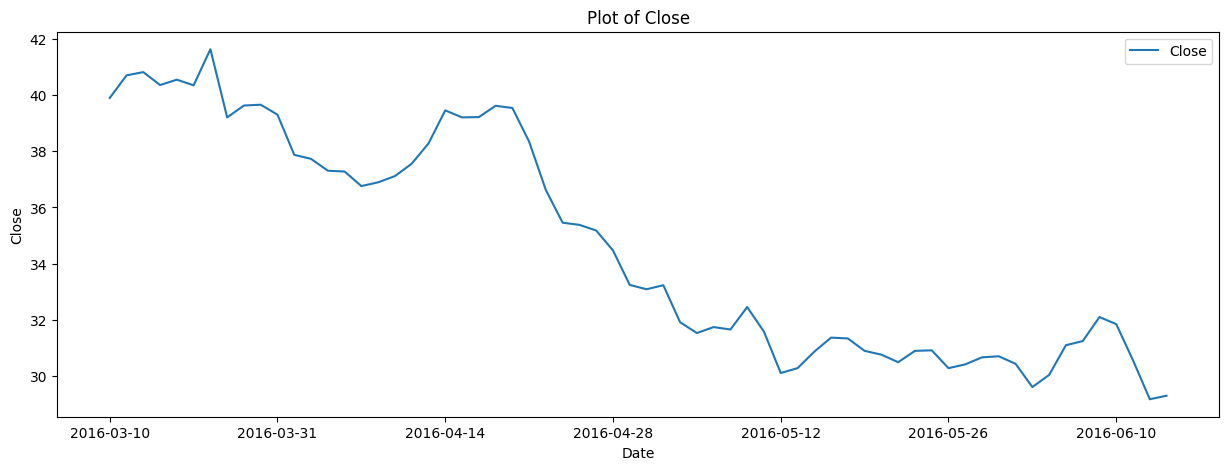

In [72]:
import matplotlib.pyplot as plt

column_to_plot = 'Close'

pandas_df = final_organized_data.select(['Date', column_to_plot]).toPandas()

pandas_df.plot(x='Date', y=column_to_plot, figsize=(15,5))
plt.xlabel("Date")
plt.ylabel(column_to_plot)
plt.title("Plot of " + column_to_plot)
plt.show()

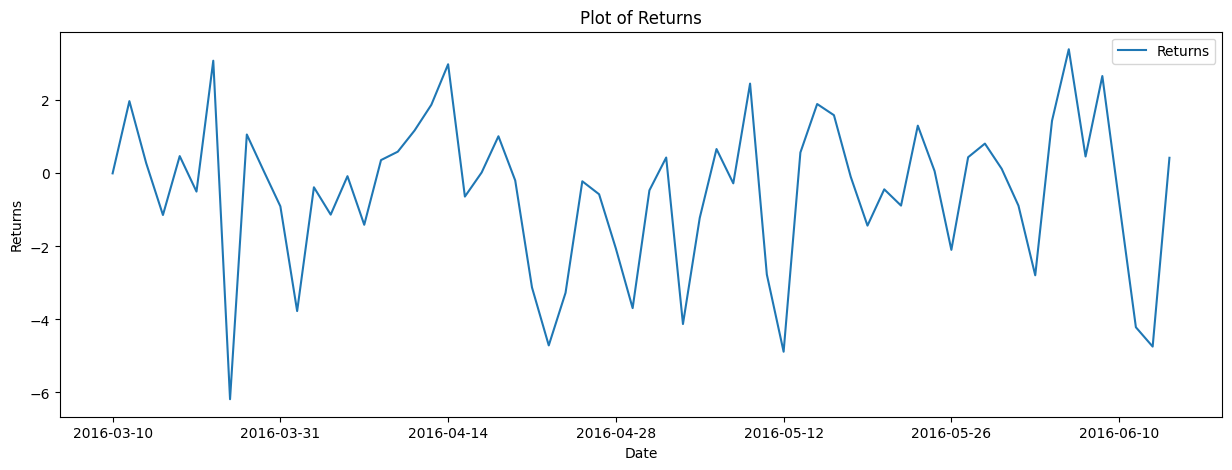

In [56]:
import matplotlib.pyplot as plt

column_to_plot = 'Returns'

pandas_df = final_organized_data.select(['Date', column_to_plot]).toPandas()

pandas_df.plot(x='Date', y=column_to_plot, figsize=(15,5))
plt.xlabel("Date")
plt.ylabel(column_to_plot)
plt.title("Plot of " + column_to_plot)
plt.show()

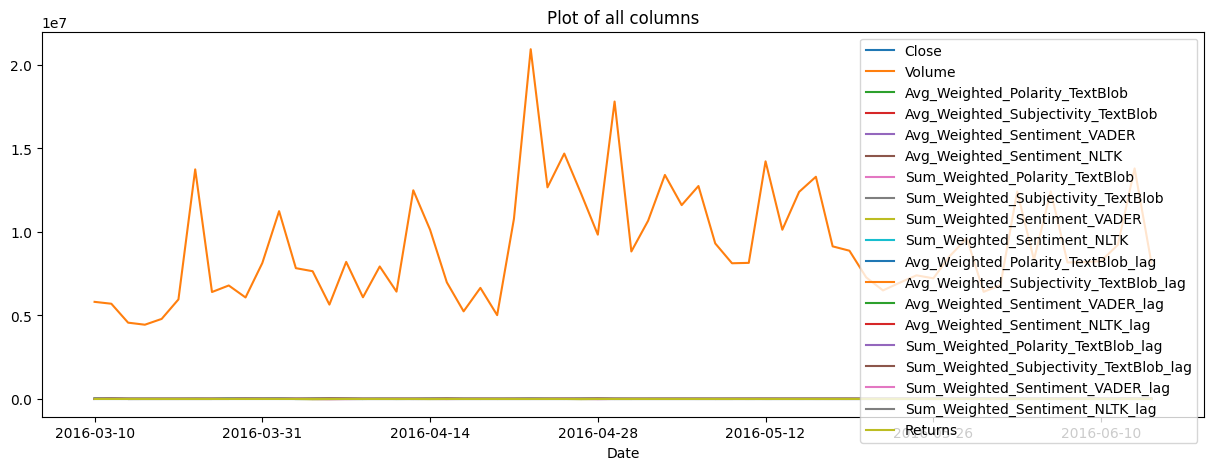

In [57]:
import matplotlib.pyplot as plt

pandas_df = final_organized_data.select('*').toPandas()
pandas_df.set_index('Date', inplace=True)

pandas_df.plot(figsize=(15,5))
plt.xlabel("Date")
plt.title("Plot of all columns")
plt.show()


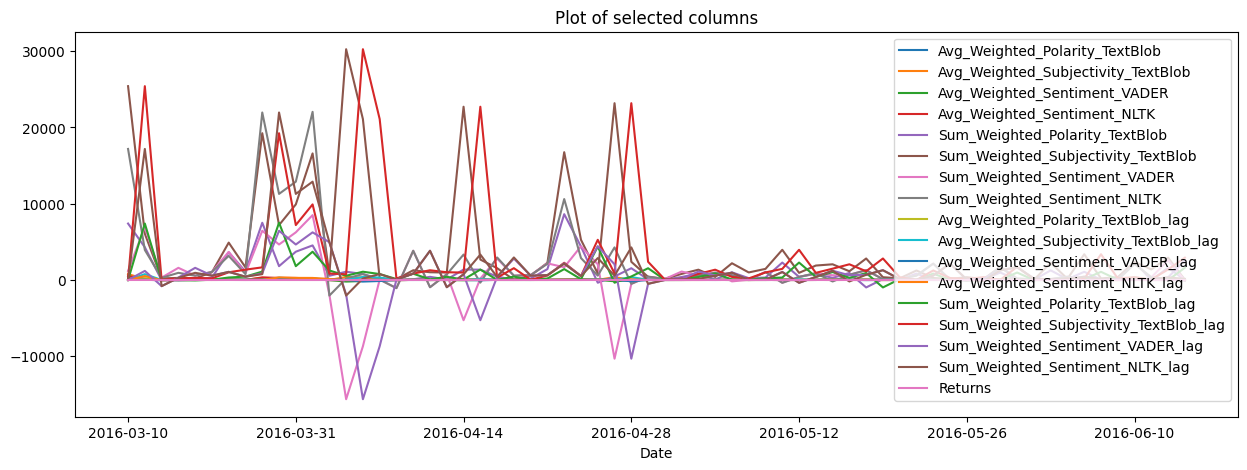

In [58]:
import matplotlib.pyplot as plt

columns_to_plot = [col for col in final_organized_data.columns if col not in ['Close', 'Volume', 'DateOfTweet']]

pandas_df = final_organized_data.select(columns_to_plot).toPandas()
pandas_df.set_index('Date', inplace=True)

pandas_df.plot(figsize=(15,5))
plt.xlabel("Date")
plt.title("Plot of selected columns")
plt.show()




In [76]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# select columns to use as predictors
predictors = ['Close', 'Volume', 'Avg_Weighted_Polarity_TextBlob', 'Avg_Weighted_Subjectivity_TextBlob', 
              'Avg_Weighted_Sentiment_VADER', 'Avg_Weighted_Sentiment_NLTK', 'Sum_Weighted_Polarity_TextBlob', 
              'Sum_Weighted_Subjectivity_TextBlob', 'Sum_Weighted_Sentiment_VADER', 'Sum_Weighted_Sentiment_NLTK', 
              'Avg_Weighted_Polarity_TextBlob_lag', 'Avg_Weighted_Subjectivity_TextBlob_lag', 
              'Avg_Weighted_Sentiment_VADER_lag', 'Avg_Weighted_Sentiment_NLTK_lag', 
              'Sum_Weighted_Polarity_TextBlob_lag', 'Sum_Weighted_Subjectivity_TextBlob_lag', 
              'Sum_Weighted_Sentiment_VADER_lag', 'Sum_Weighted_Sentiment_NLTK_lag']

# create vector assembler to combine predictors into a single feature column
assembler = VectorAssembler(inputCols=predictors, outputCol='features')

# transform the final_organized_data to add the features column
data = assembler.transform(final_organized_data).select(['Returns', 'features'])

# split the data into train and test sets
total_count = data.count()
train_count = int(total_count * 0.8)
test_count = total_count - train_count

train_data = data.limit(train_count)
test_data = data.join(train_data, on='features', how='left_anti').limit(test_count)

# create a LinearRegression object and fit the model using the train_data
lr = LinearRegression(featuresCol='features', labelCol='Returns')
model = lr.fit(train_data)

# make predictions on the test_data
predictions = model.transform(test_data)

# show the first 5 predicted values along with the actual Returns values
predictions.select(['prediction', 'Returns']).show(5)



+-------------------+-------------------+
|         prediction|            Returns|
+-------------------+-------------------+
|-0.6695299845970466| 0.4423604791110826|
|-1.8675255834410822| 0.8147928800131311|
|-0.6918722480170815|0.12517624748557313|
|-0.5419436463079309|-0.8841059031993747|
| -1.063646272164206|-2.7913174615679797|
+-------------------+-------------------+
only showing top 5 rows



In [77]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the test data
predictions = model.transform(test_data)

# Calculate RMSE
evaluator = RegressionEvaluator(labelCol="Returns", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE = %g" % rmse)

# Calculate R2
evaluator = RegressionEvaluator(labelCol="Returns", predictionCol="prediction", metricName="r2")
r2 = -evaluator.evaluate(predictions)
print("R2 = %g" % r2)


RMSE = 2.64012
R2 = 0.286777


In [78]:
# Plotting all the predictions vs the real values

In [79]:
model = lr.fit(data)

# make predictions on the test_data
predictions = model.transform(data)

# show the first 5 predicted values along with the actual Returns values
predVSreal = predictions.select(['prediction', 'Returns'])

predVSreal.show()

+--------------------+--------------------+
|          prediction|             Returns|
+--------------------+--------------------+
|0.051214533385236294|                 0.0|
|  1.5087662741362928|    1.97787387814342|
|  1.1137888960824165| 0.28173732345616975|
| 0.45994379829154597| -1.1398611255408964|
|  0.6785912890521992| 0.47271972853569505|
| 0.23845174437099015| -0.4988307442907595|
| -1.6928657451776896|   3.084702557830555|
|-0.47290152796323315|  -6.184290664921083|
|-0.22585965122735663|  1.0640859347975875|
| -0.2128504462885621| 0.07250832830832116|
|  0.8393300923884297| -0.9022277147230614|
|  -2.838909625004659|  -3.770228284523819|
| -0.8767084422658282| -0.3810205997034911|
|-0.08126763965264017| -1.1302119144783207|
| -1.2261751028600443|-0.07713096945042572|
| -1.0243604974076501| -1.4077042404538627|
| -0.5259181012319525|   0.363635912437862|
| -0.4946387242704252|  0.5938235077965481|
|  0.6229302164433432|  1.1737777841885522|
| -0.4720853187430165|  1.877834

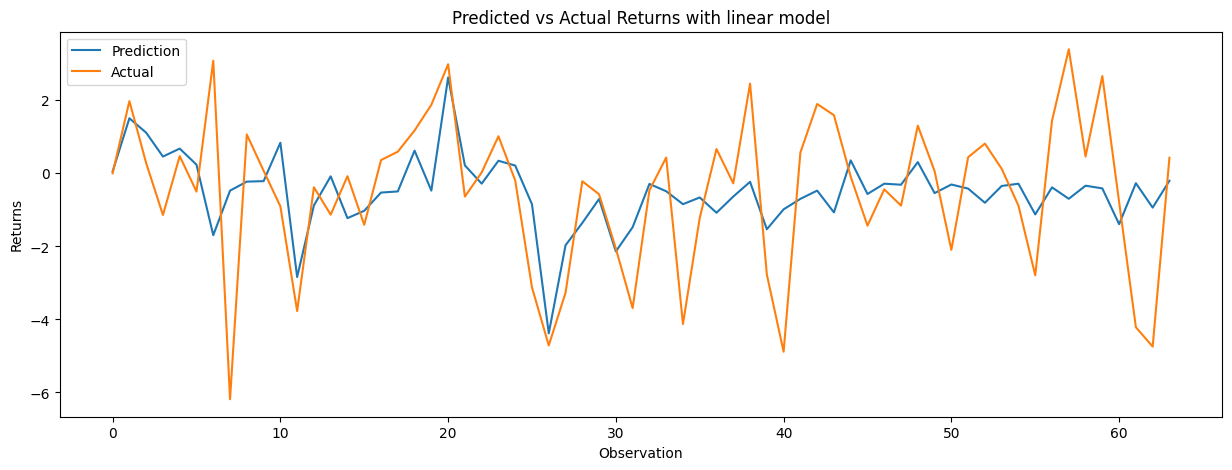

In [80]:
import matplotlib.pyplot as plt

# Convert the predicted and actual values to pandas dataframe
predVSreal_pd = predVSreal.toPandas()

# Plot the predicted and actual values as two lines
plt.figure(figsize=(15, 5))
plt.plot(predVSreal_pd['prediction'], label='Prediction')
plt.plot(predVSreal_pd['Returns'], label='Actual')
plt.xlabel("Observation")
plt.ylabel("Returns")
plt.title("Predicted vs Actual Returns with linear model")
plt.legend()
plt.show()



In [81]:
model = lr.fit(test_data)

# make predictions on the test_data
predictions = model.transform(data)

# show the first 5 predicted values along with the actual Returns values
predVSreal = predictions.select(['prediction', 'Returns'])

predVSreal.show()

+-------------------+--------------------+
|         prediction|             Returns|
+-------------------+--------------------+
| -328.9431641692437|                 0.0|
|-152.90795973137134|    1.97787387814342|
|  4.844266934867363| 0.28173732345616975|
|  6.770829758613118| -1.1398611255408964|
| 17.809446762794806| 0.47271972853569505|
|  8.821832995734141| -0.4988307442907595|
| 19.076293019101172|   3.084702557830555|
| -8.678243873215592|  -6.184290664921083|
| -48.38230725774939|  1.0640859347975875|
|  91.49802353978265| 0.07250832830832116|
|  9.403662823656006| -0.9022277147230614|
| 21.100601553731778|  -3.770228284523819|
|  33.86230544525071| -0.3810205997034911|
|-292.48417083883163| -1.1302119144783207|
| -350.9792176061583|-0.07713096945042572|
| -79.49541039190763| -1.4077042404538627|
| -5.978552646929174|   0.363635912437862|
| 3.2559653969400983|  0.5938235077965481|
|  37.16830572256197|  1.1737777841885522|
| 16.853083740131737|  1.8778344134421217|
+----------

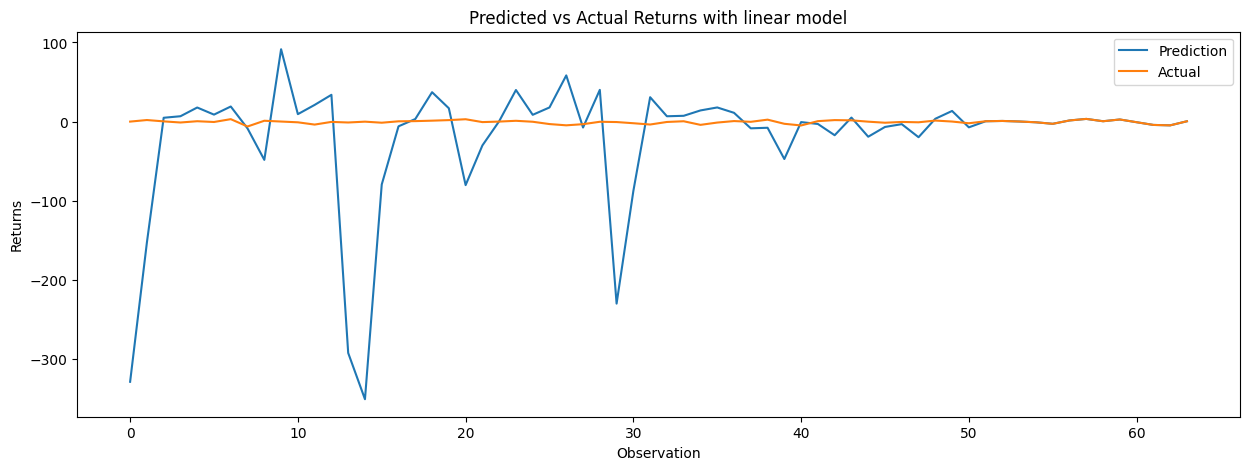

In [82]:
import matplotlib.pyplot as plt

# Convert the predicted and actual values to pandas dataframe
predVSreal_pd = predVSreal.toPandas()

# Plot the predicted and actual values as two lines
plt.figure(figsize=(15, 5))
plt.plot(predVSreal_pd['prediction'], label='Prediction')
plt.plot(predVSreal_pd['Returns'], label='Actual')
plt.xlabel("Observation")
plt.ylabel("Returns")
plt.title("Predicted vs Actual Returns with linear model")
plt.legend()
plt.show()

# RANDOM FOREST REGRESSOR

In [68]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
# Create and fit the Random Forest Regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='Returns')
model = rf.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='Returns', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2.3889587848224947


In [70]:
model = rf.fit(data)

# make predictions on the test_data
predictions2 = model.transform(data)

# show the first 5 predicted values along with the actual Returns values
predVSreal2 = predictions2.select(['prediction', 'Returns'])

predVSreal2.show()

+--------------------+--------------------+
|          prediction|             Returns|
+--------------------+--------------------+
| -0.5908767697915129|                 0.0|
|  0.4072902922262447|    1.97787387814342|
| -0.6102521842444725| 0.28173732345616975|
| -0.3868204907739465| -1.1398611255408964|
| 0.06547686429040586| 0.47271972853569505|
| 0.06668272476945514| -0.4988307442907595|
|  0.6805880328466297|   3.084702557830555|
|  -4.207045531934431|  -6.184290664921083|
| -0.0634118495385934|  1.0640859347975875|
| -0.3542252501594759| 0.07250832830832116|
|-0.23452365402239753| -0.9022277147230614|
| -0.9946422494676337|  -3.770228284523819|
| -0.3563017730673814| -0.3810205997034911|
|-0.11940109543563633| -1.1302119144783207|
| -0.6734227789651289|-0.07713096945042572|
|  -1.243936706580375| -1.4077042404538627|
|-0.10308969076149213|   0.363635912437862|
|  0.4259080995245711|  0.5938235077965481|
|  0.8271586065643136|  1.1737777841885522|
|  0.4301605646894509|  1.877834

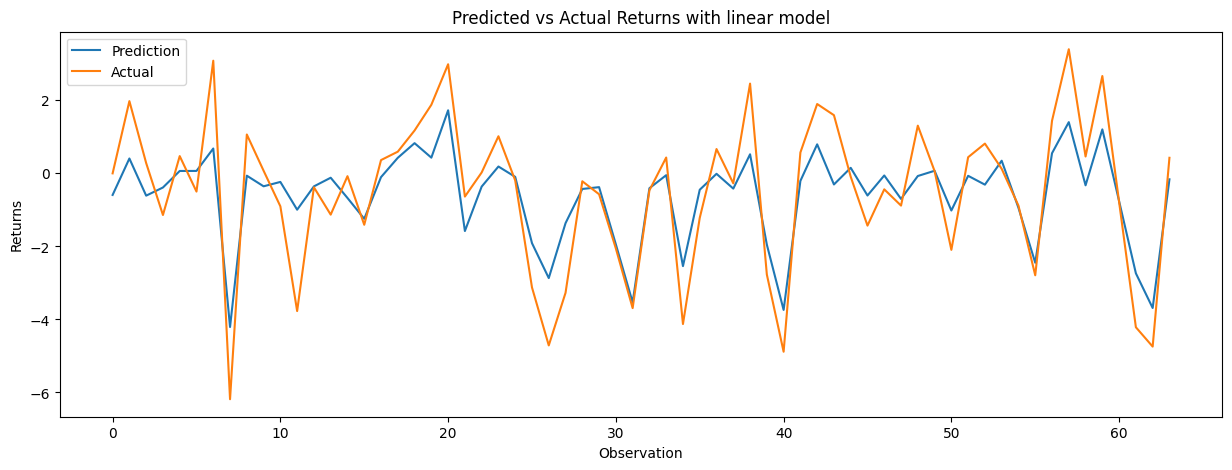

In [71]:
import matplotlib.pyplot as plt

# Convert the predicted and actual values to pandas dataframe
predVSreal2_pd = predVSreal2.toPandas()

# Plot the predicted and actual values as two lines
plt.figure(figsize=(15, 5))
plt.plot(predVSreal2_pd['prediction'], label='Prediction')
plt.plot(predVSreal2_pd['Returns'], label='Actual')
plt.xlabel("Observation")
plt.ylabel("Returns")
plt.title("Predicted vs Actual Returns with random forest regressor")
plt.legend()
plt.show()

In [73]:
model = rf.fit(test_data)

# make predictions on the test_data
predictions2 = model.transform(data)

# show the first 5 predicted values along with the actual Returns values
predVSreal2 = predictions2.select(['prediction', 'Returns'])

predVSreal2.show()

+--------------------+--------------------+
|          prediction|             Returns|
+--------------------+--------------------+
| 0.22241109111504245|                 0.0|
| 0.04387006713448116|    1.97787387814342|
|0.003675974133268323| 0.28173732345616975|
| -1.2663927110533695| -1.1398611255408964|
| -0.5906026941728324| 0.47271972853569505|
|  0.9973615183211137| -0.4988307442907595|
| -0.5241174407926753|   3.084702557830555|
|  0.5964139373478214|  -6.184290664921083|
| 0.05892975420290316|  1.0640859347975875|
| 0.04387006713448116| 0.07250832830832116|
| 0.04387006713448116| -0.9022277147230614|
| -0.5409275526559285|  -3.770228284523819|
|  1.3187810411415017| -0.3810205997034911|
|  0.5690204770252218| -1.1302119144783207|
|  0.5338034318999929|-0.07713096945042572|
|  0.9530447152691371| -1.4077042404538627|
|  0.3851570946204622|   0.363635912437862|
| 0.05642192580426784|  0.5938235077965481|
|  1.4324746595374727|  1.1737777841885522|
|-0.49598483231947954|  1.877834

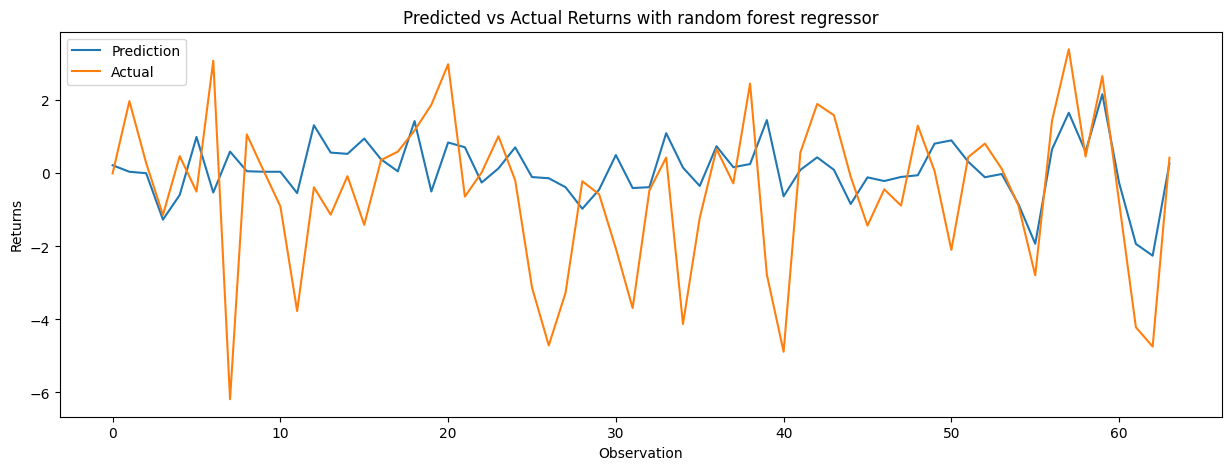

In [74]:
import matplotlib.pyplot as plt

# Convert the predicted and actual values to pandas dataframe
predVSreal2_pd = predVSreal2.toPandas()

# Plot the predicted and actual values as two lines
plt.figure(figsize=(15, 5))
plt.plot(predVSreal2_pd['prediction'], label='Prediction')
plt.plot(predVSreal2_pd['Returns'], label='Actual')
plt.xlabel("Observation")
plt.ylabel("Returns")
plt.title("Predicted vs Actual Returns with random forest regressor")
plt.legend()
plt.show()

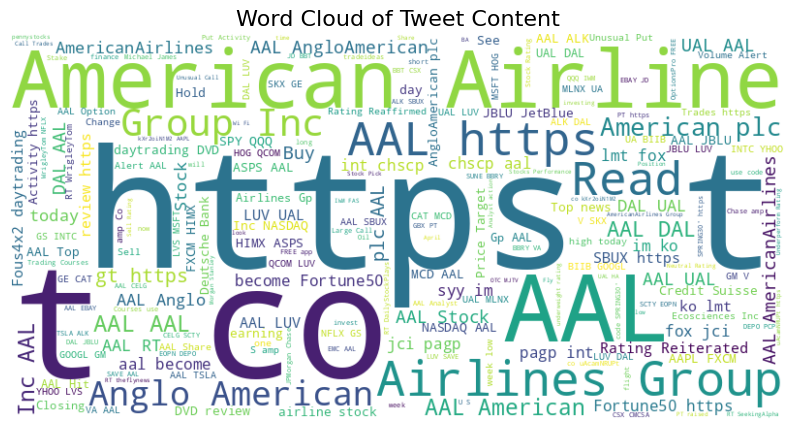

In [75]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel("AAL2.xlsx")

# Concatenate all the tweet contents into a single string
all_tweets = ' '.join(df['Tweet content'].values.astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Content', fontsize=16)
plt.show()


# Now the same but only with the text mined tokenized words (A regression)

In [89]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import explode

# transform the final_organized_data to explode the averagesBdate column into individual columns
data = final_organized_data.selectExpr('Returns', 'explode(averagesBdate) as avg_bdate')

# create vector assembler to combine the exploded columns into a single feature column
assembler = VectorAssembler(inputCols=['avg_bdate'], outputCol='features')

# transform the data to add the features column
data = assembler.transform(data).select(['Returns', 'features'])

# split the data into train and test sets
total_count = data.count()
train_count = int(total_count * 0.8)
test_count = total_count - train_count

train_data = data.limit(train_count)
test_data = data.join(train_data, on='features', how='left_anti').limit(test_count)

# create a LinearRegression object and fit the model using the train_data
lr = LinearRegression(featuresCol='features', labelCol='Returns')
model = lr.fit(train_data)

# make predictions on the test_data
predictions = model.transform(test_data)

# show the first 5 predicted values along with the actual Returns values
predictions.select(['prediction', 'Returns']).show(5)





+-------------------+-------------------+
|         prediction|            Returns|
+-------------------+-------------------+
|-0.5315681020141957| 0.4423604791110826|
|-0.5416481071069359| 0.8147928800131311|
|-0.5296740105397497| 0.8147928800131311|
|-0.5207545574560414|0.12517624748557313|
|-0.5061981471517385|0.12517624748557313|
+-------------------+-------------------+
only showing top 5 rows



In [90]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the test data
predictions = model.transform(test_data)

# Calculate RMSE
evaluator = RegressionEvaluator(labelCol="Returns", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE = %g" % rmse)

# Calculate R2
evaluator = RegressionEvaluator(labelCol="Returns", predictionCol="prediction", metricName="r2")
r2 = -evaluator.evaluate(predictions)
print("R2 = %g" % r2)

RMSE = 2.77134
R2 = 0.00431375


In [63]:
#These predictors are very bad, we should keep the results of the first models